## Spam Detection

### 1. Problem Statement

The objective of this project is to develop an NLP spam detection system that can accurately identify and filter out spam emails while minimizing false positives. Project leverage machine learning techniques to analyze email content and distinguish between legitimate emails and spam.

### 2. Exploratory Data Analysis

In [18]:
import numpy as np        
import pandas as pd       
import matplotlib.pyplot as plt  
import spacy
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
df = pd.read_csv('Emails.csv', encoding='latin-1')

#### Email length

Total number of emails: 5728
Minimum email length: 13
Maximum email length: 43952


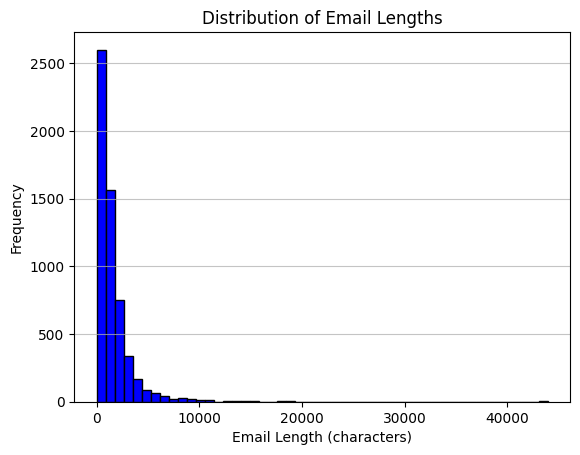

In [17]:
tot_row = df.shape[0]
min_len = df['text'].apply(len).min()
max_len = df['text'].apply(len).max()

print('Total number of emails:', tot_row)
print('Minimum email length:', min_len)
print('Maximum email length:', max_len)


plt.hist(df['text'].apply(len), bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Email Lengths')
plt.xlabel('Email Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


#### Spam vs Legit ratio

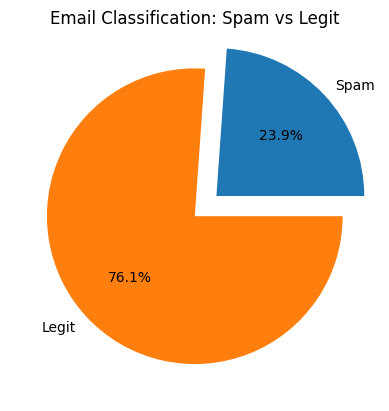

In [14]:
spam_count = df['spam'].apply(lambda x: x == 1).sum()
legit_count = df['spam'].apply(lambda x: x == 0).sum()

y = np.array([spam_count, legit_count])
labels = ["Spam", "Legit"]
myexplode = [0.2, 0]

plt.pie(y, labels=labels, autopct='%1.1f%%', explode=myexplode)
plt.title("Email Classification: Spam vs Legit")
plt.show() 

 #### Word Cloud

In [20]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha
    ]
    return " ".join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

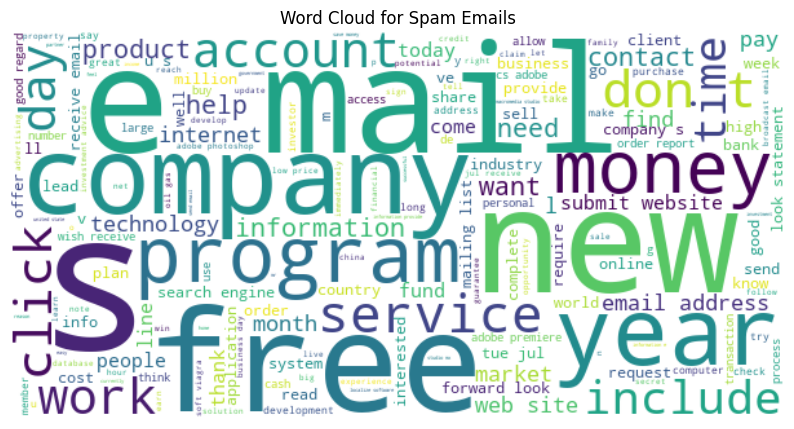

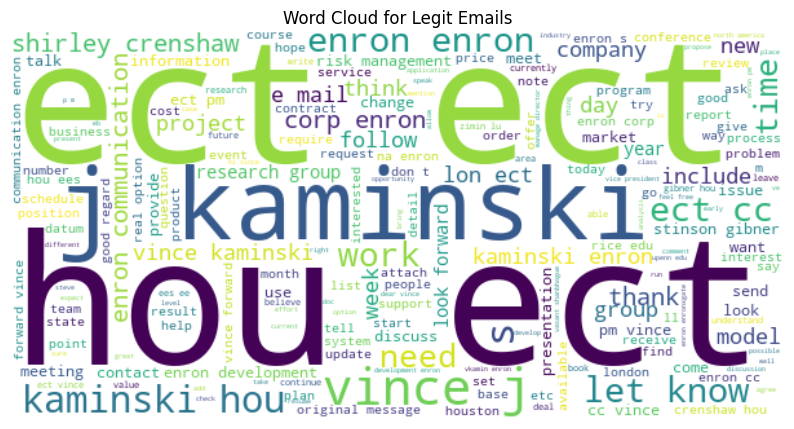

In [31]:
spam_emails = df[df['spam'] == 1]['processed_text']
legit_emails = df[df['spam'] == 0]['processed_text']

# Combine all spam emails into a single string
spam_text = ' '.join(spam_emails)
legit_text = ' '.join(legit_emails)

# Make stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.add('subject')

# Generate the word cloud
wordcloud_spam = WordCloud(width=600, height=300, background_color='white', stopwords=custom_stopwords).generate(spam_text)
wordcloud_legit = WordCloud(width=600, height=300, background_color='white', stopwords=custom_stopwords).generate(legit_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Emails')
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_legit, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Legit Emails')
plt.show()

### 3. Model Building

As a vectorizer we used CountVectorizer which works just like a Bag of Words which is basically a dictionary where each word is a key and the value is the number of times that word appears in the corpora. 

For an algorithm we chose Multinomial Naive Bayes because of its simplicity and speed. It calculates the probability of each word belonging to a spam or legitimate email based on word frequencies in the training corpus. The algorithm assumes that the occurrence of each word is independent of others, simplifying the computation and making it very efficient for large datasets. This probabilistic approach allows it to effectively handle the inherent variability and high dimensionality of text data.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('alg', MultinomialNB()),
])

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],    
    df['spam'],         
    test_size=0.2,  
    random_state=42,
)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9895287958115183


### 4. Validating the model

To validate the model we used 2 different validation methods
1. Confusion Matrix - shows amount of true positives, false positives, true negatives, and false negatives.
2. Cross-Validation - splits the data into k-folds and trains the model on k-1 folds and tests it on the remaining fold. This process is repeated k times, with each fold acting as the test set once.


In [27]:
from sklearn.metrics import confusion_matrix
import pandas as pd
y_pred = pipeline.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=list(set(df['spam'])))

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm, index=list(set(df['spam'])), columns=list(set(df['spam'])))

# Print the DataFrame
print("Confusion Matrix:")
cm_df

Confusion Matrix:


,0,1
0,852,4
1,8,282


In [28]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, df['processed_text'], df['spam'], cv=5)

print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Cross-Validation Scores: [0.9895288  0.9921466  0.9904014  0.99126638 0.99388646]
Mean Cross-Validation Score: 0.9914459254517325
